### Imports

In [1]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import numpy as np
from sklearn.metrics import r2_score
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, train_test_split
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score
from imblearn.over_sampling import RandomOverSampler
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from xgboost import XGBRegressor
from sklearn.model_selection import KFold
import numpy as np
import numpy as np
import pandas as pd
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score
from xgboost import XGBRegressor
import seaborn as sns


### Loading data

In [74]:
# File paths from user-uploaded data
mat_file_path = "./data/student-mat.csv"
por_file_path = "./data/student-por.csv"

# Reading the CSV files
student_mat = pd.read_csv(mat_file_path, sep=';')
student_por = pd.read_csv(por_file_path, sep=';')

# Reset the index of each DataFrame before concatenation
student_mat.reset_index(drop=True, inplace=True)
student_por.reset_index(drop=True, inplace=True)

# Concatenate the DataFrames
df = pd.concat([student_mat, student_por], ignore_index=True)

df = pd.get_dummies(df, columns=[ "Mjob", "Fjob", "reason", "guardian","school", "sex", "address", "famsize", "Pstatus" ]) #one hot encoder
categorical_columns = df.select_dtypes(include='object').columns
for col in categorical_columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    mapping = dict(zip(le.classes_, range(len(le.classes_))))
    print(f"Mapping: {col}", mapping)


Mapping: schoolsup {'no': 0, 'yes': 1}
Mapping: famsup {'no': 0, 'yes': 1}
Mapping: paid {'no': 0, 'yes': 1}
Mapping: activities {'no': 0, 'yes': 1}
Mapping: nursery {'no': 0, 'yes': 1}
Mapping: higher {'no': 0, 'yes': 1}
Mapping: internet {'no': 0, 'yes': 1}
Mapping: romantic {'no': 0, 'yes': 1}


### Plots

In [3]:
import matplotlib.pyplot as plt

def plot_residuals(y_test, y_pred):
    """
    Plots the residuals of a model's predictions.
    
    Parameters:
    - y_test: Array-like, actual values
    - y_pred: Array-like, predicted values
    
    Returns:
    - None: Displays a residuals plot
    """
    residuals = y_test - y_pred
    plt.figure(figsize=(5, 5))
    plt.scatter(y_test, residuals, alpha=0.7, color='blue')
    plt.axhline(0, color='red', linestyle='--')
    plt.title('Residuals of the Model')
    plt.xlabel('Actual Values')
    plt.ylabel('Residuals')
    plt.show()

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_feature_importance(model, X, top_n=None, font_size=7):
    """
    Plots the feature importances from a model and prints the least important features.
    
    Parameters:
    - model: Trained model object with `feature_importances_` attribute (e.g., XGBoost).
    - X: DataFrame containing feature columns.
    - top_n: Number of top features to display. If None, all features are displayed.
    - font_size: Font size for y-axis tick labels.
    
    Returns:
    - importance_df: DataFrame containing features and their importances sorted by importance.
    """
    # Extract feature importances and names
    feature_importances = model.feature_importances_
    feature_names = X.columns
    
    # Create a DataFrame of feature importances
    importance_df = pd.DataFrame({
        "Feature": feature_names,
        "Importance": feature_importances
    }).sort_values(by="Importance", ascending=False)
    
    # Optionally filter top_n features
    if top_n:
        importance_df = importance_df.head(top_n)
    
    # Visualize feature importance
    plt.figure(figsize=(10, 6))
    plt.barh(importance_df["Feature"], importance_df["Importance"], color='skyblue')
    plt.title("Feature Importance from Model")
    plt.xlabel("Importance")
    plt.ylabel("Feature")
    plt.gca().invert_yaxis()  # To display the highest importance at the top
    plt.gca().tick_params(axis='y', labelsize=font_size)  # Adjust y-axis tick label font size
    plt.show()

### Loading the model from part 1

In [46]:
def perform_cross_validation(X, y, n_splits=5, random_state=42, learning_rate=0.01, max_depth=5, min_child_weight=10, n_estimators=300):
    kf = KFold(n_splits=n_splits, random_state=random_state, shuffle=True)

    # Initialize lists to store results
    r2_scores = []
    all_y_vals = []
    all_y_pred = []

    # Perform cross-validation
    for train_index, val_index in kf.split(X):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]
        model = XGBRegressor(random_state=random_state, learning_rate=learning_rate, max_depth=max_depth, min_child_weight=min_child_weight, n_estimators=n_estimators)

        # Train the model
        model.fit(X_train, y_train)

        # Predict and evaluate
        y_pred = model.predict(X_val)
        all_y_vals.extend(y_val)
        all_y_pred.extend(y_pred)

        # Calculate R^2 score
        r2 = r2_score(y_val, y_pred)
        r2_scores.append(r2)

    return r2_scores, all_y_vals, all_y_pred


Average R^2: 0.8028214870340822


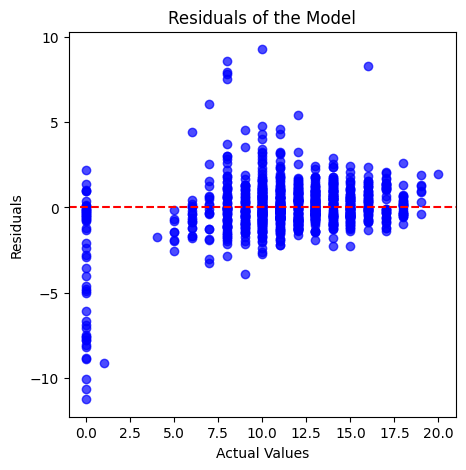

In [52]:
# Prepare the data
X = df.drop(columns=['G3'])  # Features
y = df['G3']  # Target

# Set up the model
model = XGBRegressor()
kf = KFold(n_splits=5, random_state=42, shuffle=True)

# Initialize lists to store results
r2_scores = []
all_y_vals = []
all_y_pred = []

# Perform cross-validation
for train_index, val_index in kf.split(X):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]
    model = XGBRegressor()

    # Train the model
    model.fit(X_train, y_train)

    # Predict and evaluate
    y_pred = model.predict(X_val)
    all_y_vals.extend(y_val)
    all_y_pred.extend(y_pred)

    # Calculate R^2 score
    r2 = r2_score(y_val, y_pred)
    r2_scores.append(r2)

print("Average R^2:", np.mean(r2_scores))
plot_residuals(np.array(all_y_vals), np.array(all_y_pred))

In [53]:
# Add residuals to the test set for analysis
test_set_with_residuals = X_val.copy()
test_set_with_residuals['Actual'] = y_val
test_set_with_residuals['Predicted'] = y_pred
test_set_with_residuals['Residual'] = test_set_with_residuals['Actual'] - test_set_with_residuals['Predicted']


# Sort by largest residuals (absolute errors)
test_set_with_residuals['AbsoluteError'] = test_set_with_residuals['Residual'].abs()
filtered_data = test_set_with_residuals[test_set_with_residuals['Actual'] > 0]
worst_performance = filtered_data.sort_values(by='AbsoluteError', ascending=False).head(10)

worst_performance = test_set_with_residuals.sort_values(by='AbsoluteError', ascending=False).head(10)
best_performance = test_set_with_residuals.sort_values(by='AbsoluteError', ascending=True).head(10)
pd.set_option('display.max_rows', None)  # Show all rows
pd.set_option('display.max_columns', None)  # Show all columns
worst_performance

,age,Medu,Fedu,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,Mjob_at_home,Mjob_health,Mjob_other,Mjob_services,Mjob_teacher,Fjob_at_home,Fjob_health,Fjob_other,Fjob_services,Fjob_teacher,reason_course,reason_home,reason_other,reason_reputation,guardian_father,guardian_mother,guardian_other,school_GP,school_MS,sex_F,sex_M,address_R,address_U,famsize_GT3,famsize_LE3,Pstatus_A,Pstatus_T,Actual,Predicted,Residual,AbsoluteError
337,17,3,2,1,2,0,0,1,1,0,1,1,1,1,4,3,2,2,3,2,0,7,8,False,False,True,False,False,False,False,True,False,False,False,True,False,False,False,True,False,True,False,True,False,False,True,True,False,False,True,0,8.085420,-8.085420,8.085420
742,17,4,4,2,3,0,0,1,0,1,1,1,1,0,5,3,4,1,1,5,0,7,7,False,False,False,True,False,False,False,False,True,False,False,False,False,True,False,True,False,True,False,True,False,True,False,True,False,False,True,8,0.040492,7.959508,7.959508
343,17,2,2,1,2,1,0,1,0,0,1,1,1,1,3,3,1,1,2,4,0,9,8,True,False,False,False,False,True,False,False,False,False,False,True,False,False,True,False,False,True,False,True,False,False,True,True,False,True,False,0,7.598847,-7.598847,7.598847
1035,18,4,2,2,1,1,0,0,1,0,1,1,0,0,5,4,3,4,3,3,0,7,7,False,False,True,False,False,False,False,True,False,False,False,True,False,False,True,False,False,False,True,False,True,True,False,True,False,False,True,0,4.913980,-4.913980,4.913980
875,19,2,3,1,1,1,0,0,0,0,1,0,1,1,4,4,4,1,1,2,0,9,9,True,False,False,False,False,False,False,False,True,False,True,False,False,False,False,False,True,False,True,True,False,False,True,True,False,False,True,10,5.227352,4.772648,4.772648
35,15,2,3,2,1,0,0,1,0,1,1,1,0,0,3,5,1,1,1,5,0,8,7,False,False,True,False,False,False,False,True,False,False,False,False,True,False,True,False,False,True,False,True,False,False,True,True,False,False,True,6,1.573585,4.426415,4.426415
392,21,1,1,1,1,3,0,0,0,0,0,1,0,0,5,5,3,3,3,3,3,10,8,False,False,True,False,False,False,False,True,False,False,True,False,False,False,False,False,True,False,True,False,True,True,False,True,False,False,True,7,10.266881,-3.266881,3.266881
159,16,3,3,1,2,1,0,1,1,0,1,1,1,1,4,5,5,4,4,5,4,10,12,False,False,True,False,False,False,False,False,True,False,True,False,False,False,True,False,False,True,False,False,True,False,True,True,False,False,True,12,8.737427,3.262573,3.262573
936,17,2,2,2,2,0,1,0,1,0,1,1,0,0,5,1,3,1,1,5,0,11,9,False,False,True,False,False,False,False,True,False,False,False,False,True,False,False,True,False,False,True,True,False,True,False,True,False,False,True,11,7.804284,3.195716,3.195716
1037,17,4,3,2,2,0,0,0,0,0,1,1,1,0,5,5,4,1,1,1,0,6,9,False,False,False,False,True,False,False,True,False,False,False,False,True,False,False,True,False,False,True,True,False,False,True,True,False,False,True,11,7.870176,3.129824,3.129824


# 1. Error Analysis Conclusions & work plan

To enhance our initial baseline model, we recommend two key improvements:

### 1.1. Implement k-fold cross-validation
We will employ k-fold cross-validation to optimize the selection of hyperparameters for our model. This method involves dividing the dataset into k subsets, systematically using different combinations of these subsets for training and validation. 

### 1.2. Create a new features
We will create a new column that represents the average of `G1` and `G2` scores. This new feature could provide a more stable basis for predicting `G3`, reflecting overall performance prior to the final grade.

### 1.3. Conduct feature selection
We will perform feature selection to identify which features contribute most significantly to predicting outcomes. This step will help streamline our model, ensuring only the most impactful features are used, enhancing model efficiency and potentially improving performance.

### 1.4. Exclude Outliers
Our residual plot analysis reveals a significant number of outliers primarily where `G3` equals zero, despite `G1` and `G2` having non-zero values. This pattern suggests an illogical discrepancy in how `G3` is being predicted based on the other features. To address this, we propose excluding these cases from our training dataset.

# 2. Improving Model Performance

### Hyperparameter tuning with k-fold cross-validation 

In [25]:

# Filter out rows where 'absences' is 0 and 'G3' is 0
X = df.drop(columns=['G3'])  # Features
y = df['G3']  # Target

# Set up the model
model = XGBRegressor(random_state=42)

# Set up KFold cross-validation
kf = KFold(n_splits=5, random_state=42, shuffle=True)

# Define the parameter grid
param_grid = {
    'max_depth': [3, 5, 7],
    'min_child_weight': [1, 5, 10],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 200, 300]
}

# Set up Grid Search
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='r2', cv=kf, verbose=1)

# Perform Grid Search
grid_search.fit(X, y)

# Print the best parameters and best score
print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))

# Optionally, you can use the best model found for further predictions
best_model = grid_search.best_estimator_

Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best parameters: {'learning_rate': 0.01, 'max_depth': 5, 'min_child_weight': 10, 'n_estimators': 300}
Best cross-validation score: 0.86


### creating new features and transforming existing ones

In [11]:

df_copy = df.copy()
# Creating a new feature for average parental education level
df_copy['avg_parent_edu'] = (df['Medu'] + df['Fedu']) / 2

# Creating a social support index
df_copy['social_support_index'] = df['schoolsup'].apply(lambda x: 1 if x == 'yes' else 0) + \
                             df['famsup'].apply(lambda x: 1 if x == 'yes' else 0) + \
                             df['activities'].apply(lambda x: 1 if x == 'yes' else 0)

# Creating a total alcohol consumption score
df_copy['total_alcohol'] = df['Dalc'] + df['Walc']

# Binning age into categories
df_copy['age_group'] = pd.cut(df['age'], bins=[14, 17, 20, 23], labels=['15-17', '18-20', '21+'])
df_copy = pd.get_dummies(df_copy, columns=['age_group'])

# Example of creating an interaction term between grades
df_copy['G1_G2_interaction'] = df['G1'] * df['G2']


X = df_copy.drop(columns=['G3'])  # Features
y = df_copy['G3']  # Target

# Set up KFold cross-validation
kf = KFold(n_splits=5, random_state=42, shuffle=True)
all_x_vals = []  # List to store all x_val DataFrames/Series from each fold
all_y_vals = []  # List to store all y_val DataFrames/Series from each fold

# To store scores for each fold
scores = []
r2_scores = []
all_y_pred = []
# Perform cross-validation
for train_index, val_index in kf.split(X):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]
    all_y_vals.extend(y_val)  # Append current y_val to the list
    # Train the model
    model = XGBRegressor(random_state=42, learning_rate=0.01, max_depth=5,min_child_weight=10, n_estimators=300 )

    model.fit(X_train, y_train)

    # Evaluate the model
    y_pred = model.predict(X_val)
    all_y_pred.extend(y_pred)
        
    # Calculate R^2 score
    r2 = r2_score(y_val, y_pred)

    # Calculate the number of observations and number of predictors
    n = X_val.shape[0]
    p = X_val.shape[1]

    # Calculate Adjusted R^2
    adjusted_r2 = 1 - ((1 - r2) * (n - 1) / (n - p - 1))
    
    r2_scores.append(adjusted_r2)
# Print the average score across all folds
print("Average model performance:", np.mean(r2_scores))

Average model performance: 0.8059094078756666


###### Note: Agregates features didn't improve the model

### Feature Selection

In [32]:
# Step 1: Filter rows and add a binary column
X = df.drop(columns=['G3'])  # Features
y = df['G3']  # Target

# Step 2: Feature Selection using Mutual Information
mutual_info = mutual_info_regression(X, y)
feature_scores = pd.Series(mutual_info, index=X.columns).sort_values(ascending=False)

# Select top N features (e.g., top 10 features)
top_features = feature_scores.head(20).index
X_selected = X[top_features]

print("Selected Features:")
print(top_features)

# Step 3: Set up the model and K-Fold cross-validation
r2_scores, all_y_vals, all_y_pred = perform_cross_validation(X_selected, y)
# Print results
print("Average R^2:", np.mean(r2_scores))


Selected Features:
Index(['G2', 'G1', 'failures', 'age', 'absences', 'Medu', 'school_GP',
       'higher', 'Walc', 'Fjob_teacher', 'famsize_GT3', 'sex_F', 'studytime',
       'Mjob_at_home', 'freetime', 'reason_home', 'guardian_other',
       'Mjob_other', 'address_R', 'Mjob_services'],
      dtype='object')
Average R^2: 0.8533474256514104


### Balancing data

Cuerrent distribution of G3 grades:


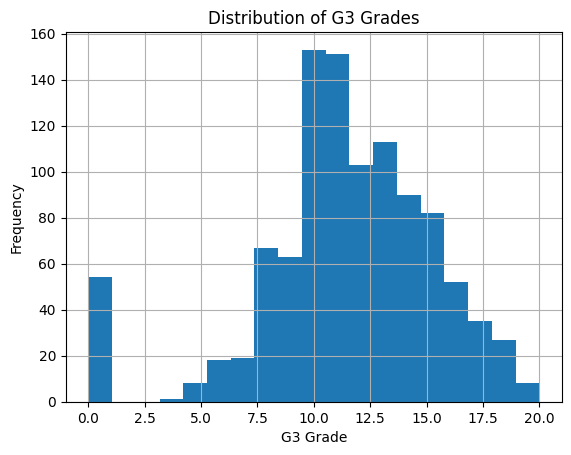

Skewness of G3: -0.9859646596265084
Kurtosis of G3: 1.7443194752957858


In [27]:
import matplotlib.pyplot as plt
print("Cuerrent distribution of G3 grades:")
# Plotting the distribution of G3 grades
df['G3'].hist(bins=len(df['G3'].unique()))
plt.title('Distribution of G3 Grades')
plt.xlabel('G3 Grade')
plt.ylabel('Frequency')
plt.show()
print("Skewness of G3:", df['G3'].skew())
print("Kurtosis of G3:", df['G3'].kurtosis())


Distribution of G3 grdes after upsampleing


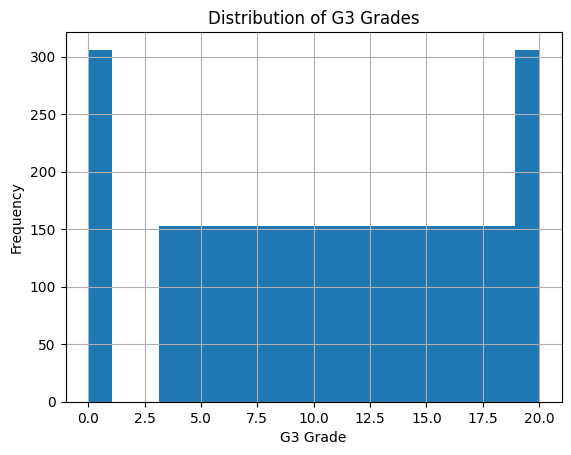

Skewness of G3: -0.18159841993721937
Kurtosis of G3: -0.9955291785297531
Average R^2: 0.9593844658258781


In [33]:
print("Distribution of G3 grdes after upsampleing")
ros = RandomOverSampler(random_state=42)
X = df.drop(columns=['G3'])  # Features
y = df['G3']  # Target

X, y = ros.fit_resample(X, y)
# Plotting the distribution of G3 grades
y.hist(bins=len(y.unique()))
plt.title('Distribution of G3 Grades')
plt.xlabel('G3 Grade')
plt.ylabel('Frequency')
plt.show()
print("Skewness of G3:", y.skew())
print("Kurtosis of G3:", y.kurtosis())
r2_scores, all_y_vals, all_y_pred = perform_cross_validation(X, y)
print("Average R^2:", np.mean(r2_scores))


### Exclude Outliers

In [34]:
df_filtered = df[~((df['G1'] != 0) & (df['G2'] != 0) & (df['G3'] == 0))]
X = df_filtered.drop(columns=['G3'])  # Features
y = df_filtered['G3']  # Target
r2_scores, all_y_vals, all_y_pred = perform_cross_validation(X, y)
# Print results
print("Average R^2:", np.mean(r2_scores))

Average R^2: 0.9167974845816833


### All the improvment together 

In [38]:
df_filtered = df[~((df['G1'] != 0) & (df['G2'] != 0) & (df['G3'] == 0))]
X = df_filtered.drop(columns=['G3'])  # Features
y = df_filtered['G3']  # Target
# Apply random oversampling
ros = RandomOverSampler(random_state=42)
X, y = ros.fit_resample(X, y)

# Feature Selection using Mutual Information
mutual_info = mutual_info_regression(X, y)
feature_scores = pd.Series(mutual_info, index=X.columns).sort_values(ascending=False)

# Select top N features (e.g., top 10 features)
top_features = feature_scores.head(20).index
X_selected = X[top_features]

# Perform cross-validation
r2_scores, all_y_vals, all_y_pred = perform_cross_validation(X_selected, y)

# Print results
print("Average model performance (R^2):", np.mean(r2_scores))

# Add residuals to the validation set for analysis
test_set_with_residuals = X.iloc[val_index].copy()  # Last validation set
test_set_with_residuals['Actual'] = y_val
test_set_with_residuals['Predicted'] = y_pred
test_set_with_residuals['Residual'] = test_set_with_residuals['Actual'] - test_set_with_residuals['Predicted']

# Sort by largest residuals (absolute errors)
test_set_with_residuals['AbsoluteError'] = test_set_with_residuals['Residual'].abs()
filtered_data = test_set_with_residuals[test_set_with_residuals['Actual'] > 0]
worst_performance = filtered_data.sort_values(by='AbsoluteError', ascending=False).head(10)

# Get worst and best performances
worst_performance = test_set_with_residuals.sort_values(by='AbsoluteError', ascending=False).head(10)
best_performance = test_set_with_residuals.sort_values(by='AbsoluteError', ascending=True).head(10)

# Display results
pd.set_option('display.max_rows', None)  # Show all rows
pd.set_option('display.max_columns', None)  # Show all columns
print("Worst Performances:")
worst_performance

Average model performance (R^2): 0.9829987077998448
Worst Performances:


,age,Medu,Fedu,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,Mjob_at_home,Mjob_health,Mjob_other,Mjob_services,Mjob_teacher,Fjob_at_home,Fjob_health,Fjob_other,Fjob_services,Fjob_teacher,reason_course,reason_home,reason_other,reason_reputation,guardian_father,guardian_mother,guardian_other,school_GP,school_MS,sex_F,sex_M,address_R,address_U,famsize_GT3,famsize_LE3,Pstatus_A,Pstatus_T,Actual,Predicted,Residual,AbsoluteError
784,19,4,4,1,1,1,0,1,0,0,1,1,1,1,3,2,5,4,4,5,5,9,10,False,False,False,False,True,False,False,True,False,False,False,True,False,False,False,False,True,True,False,True,False,False,True,True,False,False,True,11,4.506923,6.493077,6.493077
2301,16,1,1,4,1,0,1,1,0,1,0,1,1,1,5,5,5,5,5,5,0,10,10,False,False,False,True,False,False,False,False,True,False,True,False,False,False,True,False,False,True,False,True,False,False,True,True,False,False,True,16,10.866147,5.133853,5.133853
1986,18,1,1,2,2,0,0,0,0,1,1,1,0,0,1,1,1,1,1,5,6,11,12,False,False,True,False,False,False,False,True,False,False,True,False,False,False,False,True,False,False,True,True,False,False,True,True,False,False,True,9,12.035575,-3.035575,3.035575
1008,18,1,1,2,2,0,0,0,0,1,1,1,0,0,1,1,1,1,1,5,6,11,12,False,False,True,False,False,False,False,True,False,False,True,False,False,False,False,True,False,False,True,True,False,False,True,True,False,False,True,9,12.035575,-3.035575,3.035575
510,17,3,4,3,2,0,0,0,0,0,1,1,0,0,5,4,5,2,4,5,2,10,9,True,False,False,False,False,False,False,True,False,False,True,False,False,False,False,True,False,True,False,False,True,True,False,True,False,False,True,10,7.376073,2.623927,2.623927
2074,15,3,3,1,2,0,0,0,0,1,0,1,1,0,5,3,2,1,1,2,0,8,10,False,False,True,False,False,False,False,True,False,False,True,False,False,False,False,True,False,True,False,False,True,False,True,False,True,False,True,12,9.843788,2.156212,2.156212
2198,18,4,3,2,1,0,0,1,0,0,1,1,1,0,3,2,4,1,4,1,8,12,12,False,True,False,False,False,False,False,False,True,False,True,False,False,False,False,True,False,True,False,True,False,False,True,False,True,False,True,15,12.844019,2.155981,2.155981
766,17,2,2,1,2,0,0,1,0,0,1,1,1,1,3,3,1,1,2,4,18,10,12,True,False,False,False,False,True,False,False,False,False,False,True,False,False,True,False,False,True,False,True,False,False,True,True,False,True,False,14,11.951751,2.048249,2.048249
1603,15,4,3,1,2,0,1,1,1,1,1,1,1,1,5,2,2,1,1,5,8,8,8,False,False,True,False,False,False,False,True,False,False,True,False,False,False,False,True,False,True,False,True,False,False,True,False,True,True,False,6,8.021227,-2.021227,2.021227
1661,15,4,3,1,2,0,1,1,1,1,1,1,1,1,5,2,2,1,1,5,8,8,8,False,False,True,False,False,False,False,True,False,False,True,False,False,False,False,True,False,True,False,True,False,False,True,False,True,True,False,6,8.021227,-2.021227,2.021227


In [39]:
best_performance

,age,Medu,Fedu,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,Mjob_at_home,Mjob_health,Mjob_other,Mjob_services,Mjob_teacher,Fjob_at_home,Fjob_health,Fjob_other,Fjob_services,Fjob_teacher,reason_course,reason_home,reason_other,reason_reputation,guardian_father,guardian_mother,guardian_other,school_GP,school_MS,sex_F,sex_M,address_R,address_U,famsize_GT3,famsize_LE3,Pstatus_A,Pstatus_T,Actual,Predicted,Residual,AbsoluteError
2191,15,4,4,1,1,0,0,0,0,1,1,1,1,0,5,5,3,1,1,4,4,13,14,False,False,False,False,True,False,False,False,False,True,True,False,False,False,False,True,False,True,False,False,True,False,True,False,True,True,False,14,14.001529,-0.001529,0.001529
992,18,1,2,3,1,0,0,1,0,1,1,0,1,1,4,3,3,2,3,3,3,9,10,True,False,False,False,False,False,False,False,True,False,False,False,True,False,True,False,False,False,True,False,True,True,False,False,True,False,True,10,10.007191,-0.007191,0.007191
2277,16,4,4,1,3,0,0,1,0,1,0,1,1,0,5,3,2,1,1,5,4,15,16,False,False,False,False,True,False,False,False,True,False,False,True,False,False,False,True,False,True,False,True,False,False,True,True,False,False,True,16,16.007603,-0.007603,0.007603
469,16,4,3,1,3,0,1,1,0,0,1,1,1,0,5,3,5,1,1,3,2,12,13,False,False,True,False,False,True,False,False,False,False,True,False,False,False,False,True,False,True,False,True,False,False,True,True,False,False,True,13,12.991530,0.008470,0.008470
225,16,3,2,2,3,0,0,0,0,1,1,1,1,1,5,3,3,1,3,2,10,11,9,True,False,False,False,False,False,False,True,False,False,False,False,False,True,False,True,False,True,False,False,True,False,True,True,False,False,True,10,9.986543,0.013457,0.013457
2182,15,2,2,3,4,0,0,1,0,1,1,1,0,0,5,4,5,2,3,5,8,13,14,False,False,True,False,False,False,False,True,False,False,False,False,False,True,False,True,False,False,True,False,True,False,True,False,True,True,False,14,13.985852,0.014148,0.014148
2109,16,4,4,1,1,0,0,0,0,1,0,1,1,0,5,3,4,1,2,1,4,12,13,False,False,True,False,False,False,False,True,False,False,False,False,False,True,False,True,False,True,False,True,False,False,True,True,False,False,True,13,13.015809,-0.015809,0.015809
1759,16,4,4,1,2,0,0,1,0,0,1,1,0,0,4,1,3,3,5,5,18,8,6,False,False,False,False,True,False,True,False,False,False,False,False,False,True,False,True,False,True,False,False,True,False,True,False,True,True,False,7,7.016928,-0.016928,0.016928
1768,16,4,4,1,2,0,0,1,0,0,1,1,0,0,4,1,3,3,5,5,18,8,6,False,False,False,False,True,False,True,False,False,False,False,False,False,True,False,True,False,True,False,False,True,False,True,False,True,True,False,7,7.016928,-0.016928,0.016928
1796,16,4,4,1,2,0,0,1,0,0,1,1,0,0,4,1,3,3,5,5,18,8,6,False,False,False,False,True,False,True,False,False,False,False,False,False,True,False,True,False,True,False,False,True,False,True,False,True,True,False,7,7.016928,-0.016928,0.016928


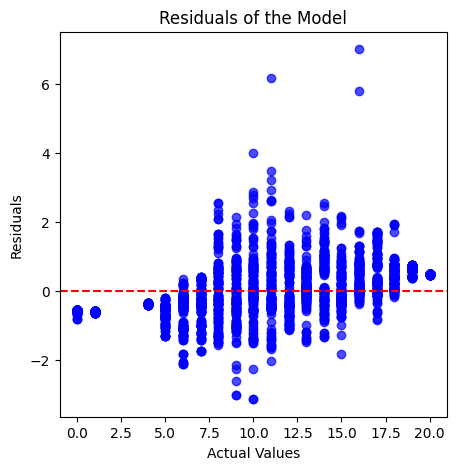

In [40]:
plot_residuals(np.array(all_y_vals), np.array(all_y_pred))

# 3. Analyzing the Improved Model


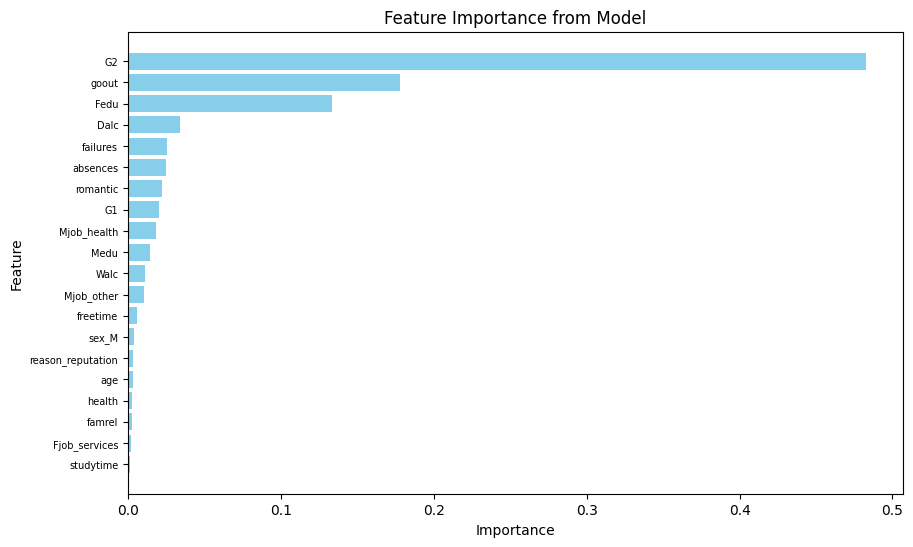

In [45]:
plot_feature_importance(model, X_selected)

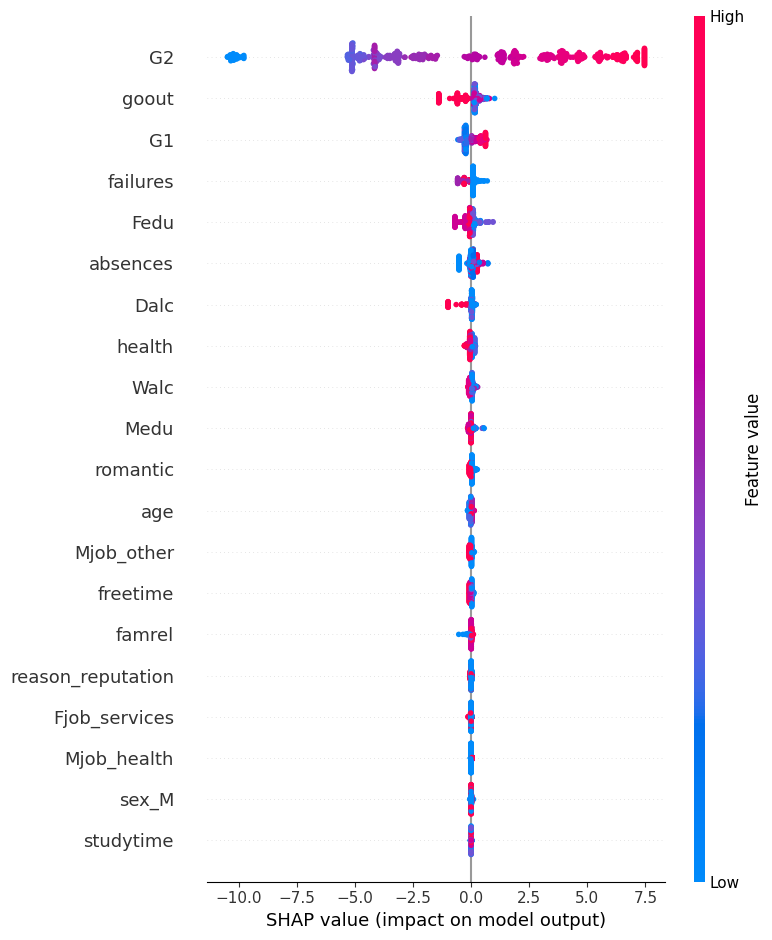

In [44]:
import shap
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split

# Assuming X_selected and y are already defined from your previous steps
X_train, X_val, y_train, y_val = train_test_split(X_selected, y, test_size=0.2, random_state=42)

# Train a model on the entire training dataset
model = XGBRegressor(random_state=42, learning_rate=0.01, max_depth=5, min_child_weight=10, n_estimators=300)
model.fit(X_train, y_train)

# Create a SHAP explainer object using the model
explainer = shap.Explainer(model)

# Compute SHAP values - this can be computationally intensive
shap_values = explainer(X_val)

# Visualize the SHAP values
shap.summary_plot(shap_values, X_val)


### SHAP Value Analysis Summary

- **G2 and G1**: Higher scores in `G2` and `G1` significantly increase the model's predicted final grades, indicating strong positive impacts.
- **Absences**: More absences negatively affect the model's predictions, suggesting they lead to lower grades.
- **Goout**: Going out less frequently positively impacts grades, implying that less social activity correlates with better academic performance.
- **Failures**: Fewer failures positively influence predictions, indicating that a history of fewer academic failures predicts higher grades.


### Model Performance Comparison

The comparison between the original and improved models based on the average R² scores shows a significant enhancement in model accuracy and generalizability:

- **Original Model Average R²**: `0.8028`
- **Improved Model Average R²**: `0.9830`


### Residual Plots for Original vs. Improved Model

Original Model RMSE: 1.8449161425674343
Improved Model RMSE: 1.0947767244639341


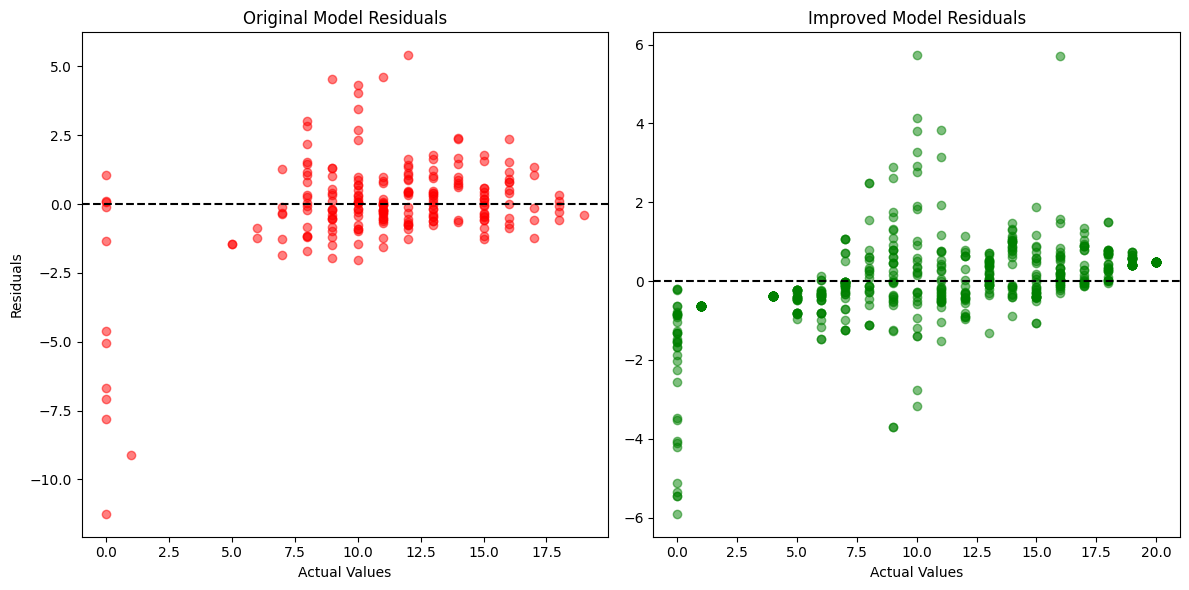

Original Model RMSE: 0.9461073244058971
Improved Model RMSE: 0.7530530730232539


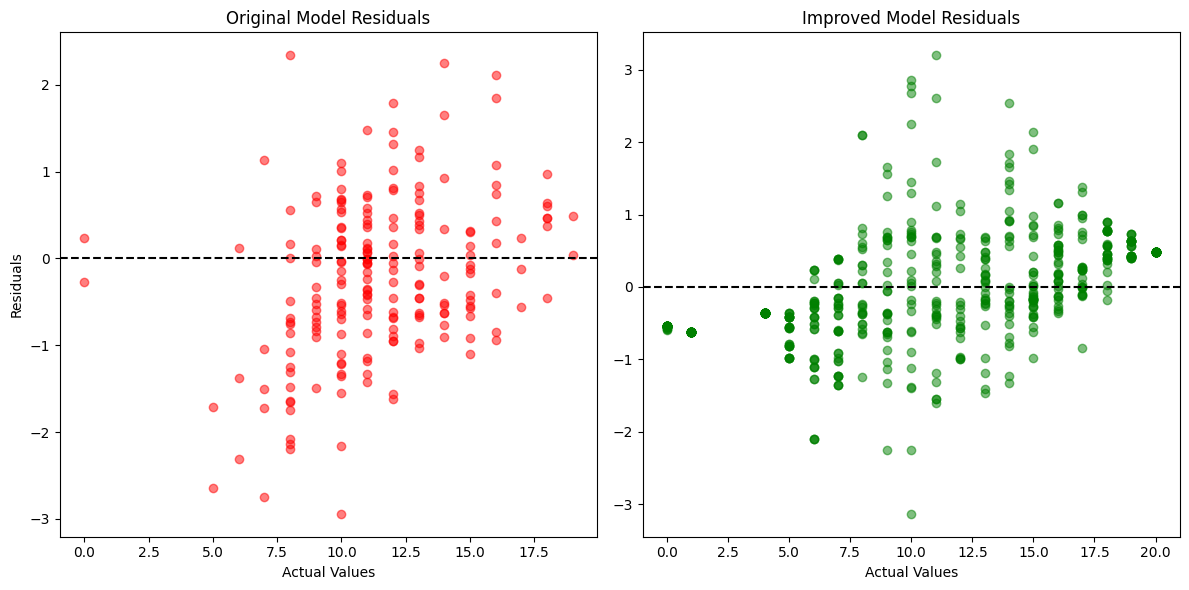

In [80]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from imblearn.over_sampling import RandomOverSampler
from sklearn.feature_selection import mutual_info_regression
from xgboost import XGBRegressor
import matplotlib.pyplot as plt

def train_and_evaluate_models(df):
    # Prepare data for original model
    X_original = df.drop(columns=['G3'])
    y = df['G3']
    X_train_original, X_val_original, y_train_original, y_val_original = train_test_split(X_original, y, test_size=0.2, random_state=42)

    # Prepare data for improved model
    X_improved = X_original.copy()  # As X_original and X_improved start the same
    ros = RandomOverSampler(random_state=42)
    X_improved, y_improved = ros.fit_resample(X_improved, y)

    # Feature Selection using Mutual Information
    mutual_info = mutual_info_regression(X_improved, y_improved)
    feature_scores = pd.Series(mutual_info, index=X_improved.columns).sort_values(ascending=False)
    top_features = feature_scores.head(20).index
    X_improved = X_improved[top_features]
    X_train_improved, X_val_improved, y_train_improved, y_val_improved = train_test_split(X_improved, y_improved, test_size=0.2, random_state=42)

    # Train original model
    original_model = XGBRegressor(random_state=42)
    original_model.fit(X_train_original, y_train_original)
    original_preds = original_model.predict(X_val_original)

    # Train improved model
    improved_model = XGBRegressor(random_state=42, learning_rate=0.01, max_depth=5, min_child_weight=10, n_estimators=300)
    improved_model.fit(X_train_improved, y_train_improved)
    improved_preds = improved_model.predict(X_val_improved)

    # Calculate residuals
    original_residuals = y_val_original - original_preds
    improved_residuals = y_val_improved - improved_preds

    # Calculate and print RMSE
    original_rmse = np.sqrt(mean_squared_error(y_val_original, original_preds))
    improved_rmse = np.sqrt(mean_squared_error(y_val_improved, improved_preds))
    print(f"Original Model RMSE: {original_rmse}")
    print(f"Improved Model RMSE: {improved_rmse}")

    # Plot residuals
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.scatter(y_val_original, original_residuals, color='red', alpha=0.5)
    plt.axhline(0, linestyle='--', color='black')
    plt.title('Original Model Residuals')
    plt.xlabel('Actual Values')
    plt.ylabel('Residuals')

    plt.subplot(1, 2, 2)
    plt.scatter(y_val_improved, improved_residuals, color='green', alpha=0.5)
    plt.axhline(0, linestyle='--', color='black')
    plt.title('Improved Model Residuals')
    plt.xlabel('Actual Values')

    plt.tight_layout()
    plt.show()
    return original_model, improved_model, X_train_original, X_train_improved
df_filtered = df[~((df['G1'] != 0) & (df['G2'] != 0) & (df['G3'] == 0))]
train_and_evaluate_models(df)
original_model, improved_model, X_train_original, X_train_improved = train_and_evaluate_models(df_filtered)

## Model Performance Analysis Using All Examples in the Dataset

The residual plots and RMSE values for both models clearly demonstrate enhanced model performance:

- **Original Model RMSE**: 1.8449
- **Improved Model RMSE**: 1.0948

**Observations**:
- **Reduced RMSE**: A significant decrease in RMSE from 1.8449 to 1.0948 indicates a substantial improvement in prediction accuracy.
- **Tighter Residual Distribution**: The improved model shows residuals more tightly clustered around the zero line, suggesting more consistent and reliable predictions.

## Model Performance Analysis Excluding Anomalous `G3=0` Outliers

After removing data points where `G3=0` while `G1!=0` and `G2!=0`, which were identified as anomalies, both models show improvements in prediction accuracy, as evidenced by the residual plots and RMSE values:

- **Original Model RMSE**: 0.9461
- **Improved Model RMSE**: 0.7531

**Observations**:
- **Reduction in RMSE**: There's a noticeable decrease in RMSE from 0.9461 in the original model to 0.7531 in the improved model, indicating a significant improvement in prediction accuracy.
- **Tighter Residual Distribution**: The improved model displays residuals more closely clustered around the zero line, suggesting more precise predictions.
- **Fewer Outliers**: The removal of identified anomalies has resulted in fewer extreme residuals, particularly around zero, enhancing the overall reliability and stability of the model predictions.


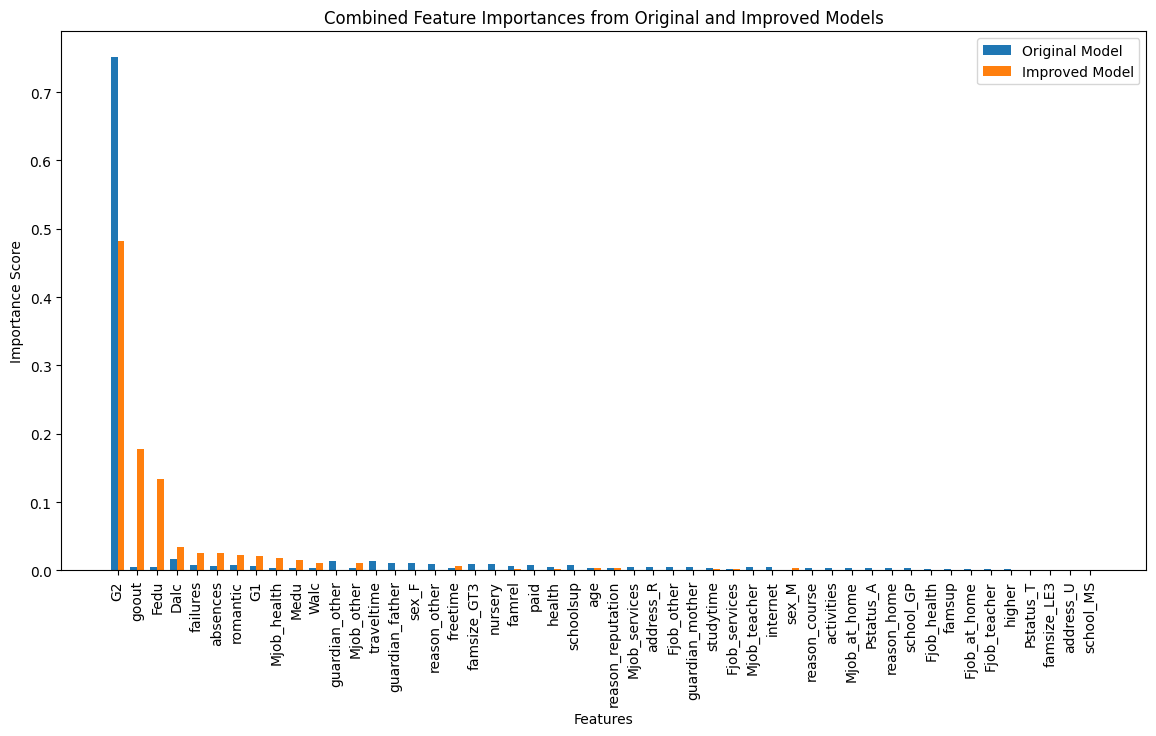

In [81]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming feature_importances_ are available and the models are using Booster objects (like XGBoost)
original_features = {f: importance for f, importance in zip(X_train_original.columns, original_model.feature_importances_)}
improved_features = {f: importance for f, importance in zip(X_train_improved.columns, improved_model.feature_importances_)}

# Create a union of all feature names from both models
all_features = set(original_features.keys()).union(set(improved_features.keys()))

# Initialize dictionaries to store combined importances
combined_original = {feature: original_features.get(feature, 0) for feature in all_features}
combined_improved = {feature: improved_features.get(feature, 0) for feature in all_features}

# Sort features by total importance from both models (optional, but helps in visualization)
sorted_features = sorted(all_features, key=lambda x: combined_original[x] + combined_improved[x], reverse=True)

# Extract importances in the order of sorted features
sorted_original_importances = [combined_original[feature] for feature in sorted_features]
sorted_improved_importances = [combined_improved[feature] for feature in sorted_features]

# Plotting
fig, ax = plt.subplots(figsize=(14, 7))
index = np.arange(len(sorted_features))
bar_width = 0.35

rects1 = ax.bar(index - bar_width/2, sorted_original_importances, bar_width, label='Original Model')
rects2 = ax.bar(index + bar_width/2, sorted_improved_importances, bar_width, label='Improved Model')

ax.set_xlabel('Features')
ax.set_ylabel('Importance Score')
ax.set_title('Combined Feature Importances from Original and Improved Models')
ax.set_xticks(index)
ax.set_xticklabels(sorted_features, rotation=90)
ax.legend()

plt.show()


### Feature Importance Analysis

The comparison of feature importances between the original and improved models reveals significant strategic adjustments:

- **Reduced Dependence on G2**: The importance of 'G2' is notably lower in the improved model, indicating a shift towards less reliance on this single feature.
- **Increased Diversity in Feature Utilization**: The improved model shows enhanced utilization of a variety of other features, including 'goout', 'Fedu', and 'Mjob_health', suggesting a more holistic approach to data.
- **Enhanced Model Accuracy and Generalization**: By diversifying the features it relies upon, the improved model is likely more robust and accurate, capable of generalizing better across different datasets.


Original Model RMSE: 1.8449161425674343
Improved Model RMSE: 1.0947767244639341


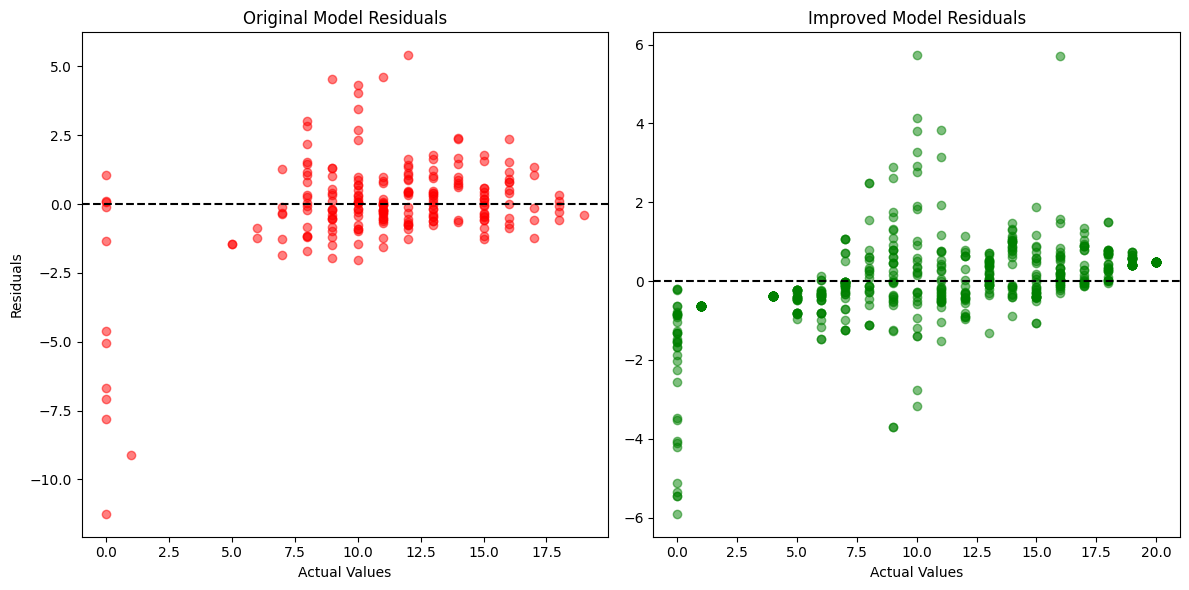

Original Model RMSE: 0.9461073244058971
Improved Model RMSE: 0.7530530730232539


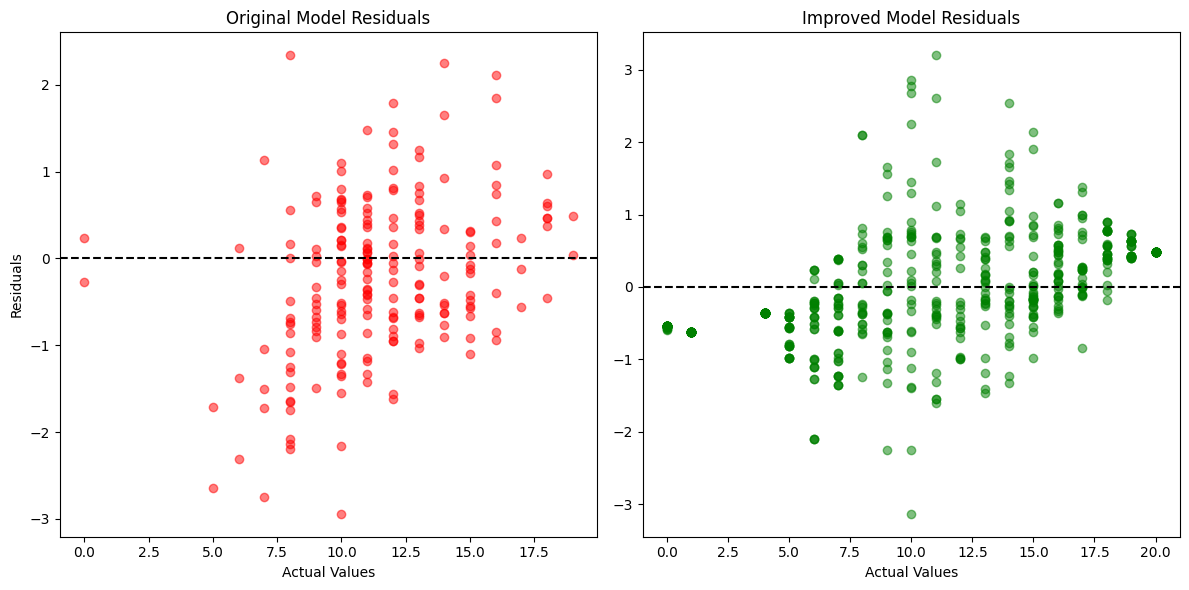

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from imblearn.over_sampling import RandomOverSampler
from sklearn.feature_selection import mutual_info_regression
from xgboost import XGBRegressor
import matplotlib.pyplot as plt

def train_and_evaluate_models(df):
    # Prepare data for original model
    X_original = df.drop(columns=['G3'])
    y = df['G3']
    X_train_original, X_val_original, y_train_original, y_val_original = train_test_split(X_original, y, test_size=0.2, random_state=42)

    # Prepare data for improved model
    X_improved = X_original.copy()  # As X_original and X_improved start the same
    ros = RandomOverSampler(random_state=42)
    X_improved, y_improved = ros.fit_resample(X_improved, y)

    # Feature Selection using Mutual Information
    mutual_info = mutual_info_regression(X_improved, y_improved)
    feature_scores = pd.Series(mutual_info, index=X_improved.columns).sort_values(ascending=False)
    top_features = feature_scores.head(20).index
    X_improved = X_improved[top_features]
    X_train_improved, X_val_improved, y_train_improved, y_val_improved = train_test_split(X_improved, y_improved, test_size=0.2, random_state=42)

    # Train original model
    original_model = XGBRegressor(random_state=42)
    original_model.fit(X_train_original, y_train_original)
    original_preds = original_model.predict(X_val_original)

    # Train improved model
    improved_model = XGBRegressor(random_state=42, learning_rate=0.01, max_depth=5, min_child_weight=10, n_estimators=300)
    improved_model.fit(X_train_improved, y_train_improved)
    improved_preds = improved_model.predict(X_val_improved)

    # Calculate residuals
    original_residuals = y_val_original - original_preds
    improved_residuals = y_val_improved - improved_preds

    # Calculate and print RMSE
    original_rmse = np.sqrt(mean_squared_error(y_val_original, original_preds))
    improved_rmse = np.sqrt(mean_squared_error(y_val_improved, improved_preds))
    print(f"Original Model RMSE: {original_rmse}")
    print(f"Improved Model RMSE: {improved_rmse}")

    # Plot residuals
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.scatter(y_val_original, original_residuals, color='red', alpha=0.5)
    plt.axhline(0, linestyle='--', color='black')
    plt.title('Original Model Residuals')
    plt.xlabel('Actual Values')
    plt.ylabel('Residuals')

    plt.subplot(1, 2, 2)
    plt.scatter(y_val_improved, improved_residuals, color='green', alpha=0.5)
    plt.axhline(0, linestyle='--', color='black')
    plt.title('Improved Model Residuals')
    plt.xlabel('Actual Values')

    plt.tight_layout()
    plt.show()
    return original_model, improved_model, X_train_original, X_train_improved
df_filtered = df[~((df['G1'] != 0) & (df['G2'] != 0) & (df['G3'] == 0))]
train_and_evaluate_models(df)
original_model, improved_model, X_train_original, X_train_improved = train_and_evaluate_models(df_filtered)

## Concise Analysis of Improved Model Insights

### Feature Significance
- **Reduced Reliance on G2**: The model now shows a diminished dependence on the 'G2' feature, diversifying the influence across additional variables. This change reduces potential overfitting and enhances model robustness.
- **Increased Importance of Other Factors**: Features such as 'goout' (social activities) and 'Fedu' (father's education level) have gained prominence, indicating a shift towards integrating broader lifestyle and socio-economic factors.

### Biases or Trends
- **Balanced Feature Weights**: By lessening the weight on 'G2', the model mitigates biases related to prior academic performance, thus allowing a more equitable prediction that considers a wider range of influences.

### Data Insights and Modifications
- **Anomalous Data Points**: Observations where students achieved `G3=0` did not align with their other features—for example, having good grades in previous exams and zero absences, suggesting that these scores did not reflect their true potential. This led to the decision to remove these outliers from the dataset, as their presence was likely due to external factors such as absence from the exam, not captured in the data.
- **Unexpected Influences**: The significant role of factors like 'goout' and 'Fedu' was surprising. These insights suggest that academic outcomes are influenced by a complex interplay of various elements beyond mere academic history.

### Future Considerations
- **Presence Indication**: Future data collection should include indicators of whether a student was present for the exam. This information will help further refine model predictions and address anomalies more effectively.


## Potential Applications of Predictive Analytics in Education

### 1. Predictive Tools for Academic Success
Develop models to identify students at risk of underperformance, enabling early interventions such as tutoring or counseling to enhance student outcomes.

### 2. Customized Learning Plans
Leverage feature insights to create personalized educational programs, addressing individual needs and balancing academic and extracurricular activities, particularly focusing on social factors like 'goout'.

### 3. App Development
Create mobile apps for students and parents to monitor academic progress and receive real-time suggestions for improvement based on predictive analytics.

### 4. Grant and Scholarship Allocation
Use predictive models to identify and support students who are most likely to benefit from scholarships and financial aid, considering their academic potential and socio-economic status.


## Concise Summary of Model Improvements and Insights

### Key Findings and Actionable Insights
- **Reduced Reliance on G2**: The model's decreased dependence on the 'G2' feature diversifies the influence across additional variables, enhancing prediction robustness.
- **Increased Importance of Socio-Economic and Lifestyle Factors**: Features such as 'goout' and 'Fedu' are more prominent, suggesting interventions that balance academic and extracurricular activities could be beneficial.
- **Effective Anomaly Management**: Removing outliers where `G3=0` was deemed anomalous has led to more consistent and accurate predictions.

### Justification and Impact on Performance
- **Improved Accuracy**: The shift in feature importance and outlier management has reduced the RMSE from 0.9461 to 0.7531, indicating a significant improvement in model accuracy.
- **Enhanced Reliability**: The model now better handles diverse data, offering more reliable predictions across varied student profiles.
- **Broader Application Potential**: The model’s enhancements make it a versatile tool for educational institutions to implement targeted support and improve educational outcomes.

These enhancements not only refine the model's predictive capabilities but also increase its practical utility in educational settings.
